In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset
import os
from source.data_processing.image_reading import read_image
from source.data_processing.transformations import sample_random_affine_matrix
from typing import Tuple, List
from torchvision import transforms
from kornia.geometry.transform import warp_affine
from matplotlib import pyplot as plt
from source.visualization.image_visualization import plot_images_with_matches
from source.data_processing.keypoints import generate_image_grid_coordinates
from source.data_processing.transformations import *
from source.visualization.image_visualization import plot_image_with_crop

In [2]:
class BrainDataset(Dataset):
    def __init__(self, images_directory: str, train: bool, transform: transforms.transforms.Compose) -> None:
        super().__init__()
        self.train = train
        self.image_names = self._get_image_names(images_directory=images_directory)
        self.images_directory = images_directory
        self.transform = transform

    def __len__(self) -> int:
        """
        Return the number of images in the dataset -1, since this dataset works with pairs of images.
        """
        return len(self.image_names[:-1])

    def _get_image_names(self, images_directory: str) -> List[str]:
        """
        Load image names from the directory based on training or testing phase.

        Args:
            images_directory (str): Directory path containing images.

        Returns:
            List[str]: A list of image file names.
        """
        image_files = os.listdir(images_directory)
        return image_files[:-2] if self.train else image_files[-2:]
    
    def _get_images(self, index:int)->Tuple[torch.Tensor, torch.Tensor]:
        """
        Load a pair of images from the dataset.

        Args:
            index (int): Index of the pair of images.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: A tuple containing the images.
        """
        image_1 = read_image(os.path.join(self.images_directory, self.image_names[index]))
        image_2 = read_image(os.path.join(self.images_directory, self.image_names[index+1]))

        image_1 = transforms.ToTensor()(image_1)
        image_2 = transforms.ToTensor()(image_2)

        return image_1, image_2
    
    def __getitem__(self, index: int):
        # Read whole image
        image_1, image_2 = self._get_images(index=index)

        if self.transform:
            image_1 = self.transform(image_1)
            image_2 = self.transform(image_2)
        
        transformation_matrix = sample_random_affine_matrix(self.transformation_threshold).to(self.device)
        image_2_transformed = warp_affine(image_2, transformation_matrix)

In [3]:
images_directory = "data/cyto_downscaled_3344_3904/"
image_names = os.listdir(images_directory)
image_1, image_2 = read_image(os.path.join(images_directory, image_names[0])), read_image(os.path.join(images_directory, image_names[1]))
image_1 = transforms.ToTensor()(image_1)
image_2 = transforms.ToTensor()(image_2)

In [4]:
image_size = image_1.shape[-2:]

In [5]:
transformation_matrix = sample_random_affine_matrix(range_limit=0.3)
image_2 = warp_affine(src=image_2.unsqueeze(0), M=transformation_matrix, dsize=image_size, mode="nearest")[0]

In [6]:
grid_coordinates = generate_image_grid_coordinates(image_size)

In [7]:
grid_coordinates_transformed = transform_grid_coordinates(grid_coordinates, transformation_matrix[0])

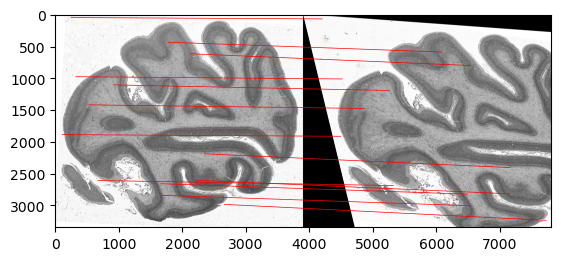

In [8]:
plot_images_with_matches(image_1, image_2, grid_coordinates_transformed, number_of_matches=20, sample_keypoints_randomly=True)

In [9]:
from source.data_processing.cropping import sample_crop_coordinates, crop_image

In [15]:
crop_size = 640
max_translation_shift = 50

crop_position_image_1, crop_position_image_2 = sample_crop_coordinates(grid_coordinates_transformed=grid_coordinates_transformed, 
                                                                            crop_size=crop_size, 
                                                                            max_translation_shift=max_translation_shift)

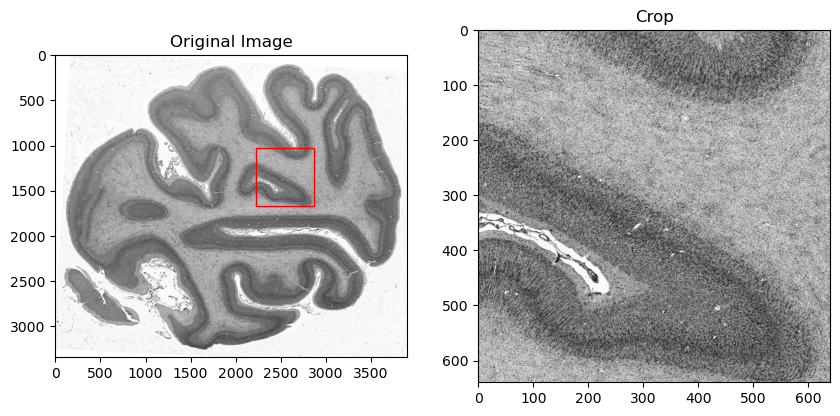

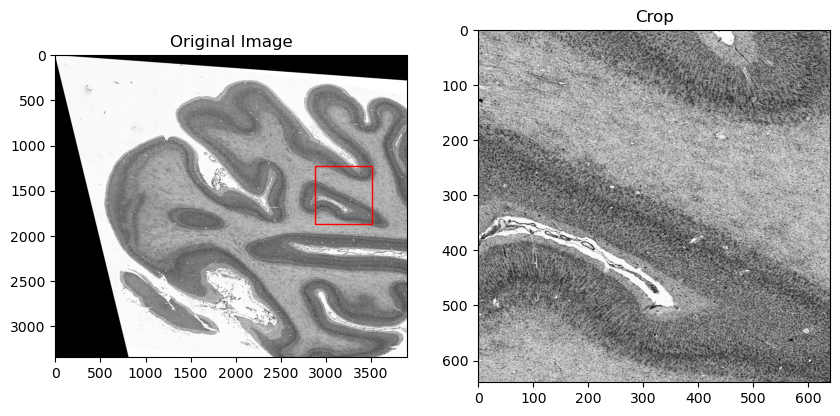

In [16]:
image_1_crop = crop_image(image=image_1, crop_position=crop_position_image_1, crop_size=crop_size)
image_2_crop = crop_image(image=image_2, crop_position=crop_position_image_2, crop_size=crop_size)
plot_image_with_crop(original_image=image_1, crop_image=image_1_crop, crop_position=crop_position_image_1)
plot_image_with_crop(original_image=image_2, crop_image=image_2_crop, crop_position=crop_position_image_2)

In [17]:
def create_transformed_crop_grid(
    grid_coordinates_transformed: torch.Tensor, 
    crop_position_image_1: tuple, 
    crop_position_image_2: tuple, 
    crop_size: int
) -> torch.Tensor:
    """
    Creates a grid mapping between two cropped images from their transformed grid coordinates.

    This function adjusts the grid coordinates of a transformed image (grid_coordinates_transformed)
    to create a mapping grid specific to the cropped regions of the original and transformed images.
    It maps each pixel's position from the crop of the original image (image_1) to its corresponding 
    position in the crop of the transformed image (image_2).

    Args:
        grid_coordinates_transformed (torch.Tensor): The grid coordinates of the transformed image.
        crop_start_img1 (tuple): The (x, y) coordinates of the top-left corner of the crop in the original image (image_1).
        crop_start_img2 (tuple): The (x, y) coordinates of the top-left corner of the crop in the transformed image (image_2).
        crop_size (int): The size of the square crop.

    Returns:
        torch.Tensor: A grid mapping each pixel from the crop in image_1 to its corresponding location in the crop of image_2.

    Note: 
        The grid is of shape (crop_size, crop_size, 2), where the last dimension represents the x and y coordinates of each pixel.
        The grid is initialized with -1, which is used to mark pixels that fall outside the bounds of the transformed image.
    """
    
    # Extracting the corresponding region from grid_coordinates_transformed
    x1, y1 = crop_position_image_1
    transformed_region = grid_coordinates_transformed[y1:y1+crop_size, x1:x1+crop_size]

    # Adjusting the coordinates relative to the top-left corner of image_2_crop
    x2, y2 = crop_position_image_2
    transformed_region_adjusted = transformed_region - torch.tensor([x2, y2])

    # Filtering out coordinates that fall outside the bounds of image_2_crop
    valid_mask = (transformed_region_adjusted >= 0) & (transformed_region_adjusted < crop_size)
    valid_mask = valid_mask.all(dim=2)
    transformed_crop_grid = torch.where(valid_mask.unsqueeze(-1), transformed_region_adjusted, -1)  # Mark invalid coordinates with -1

    return transformed_crop_grid


In [18]:
transformed_crop_grid = create_transformed_crop_grid(grid_coordinates_transformed=grid_coordinates_transformed,
                                                        crop_position_image_1=crop_position_image_1,
                                                        crop_position_image_2=crop_position_image_2,
                                                        crop_size=crop_size)

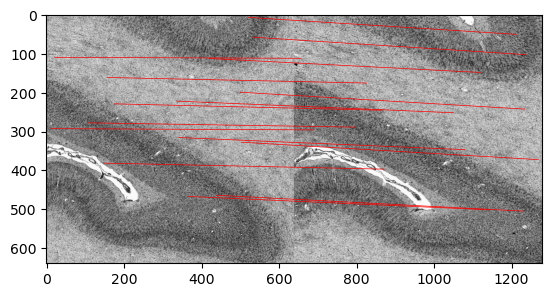

In [19]:
plot_images_with_matches(image_1_crop, image_2_crop, transformed_crop_grid, number_of_matches=20, sample_keypoints_randomly=True)

In [26]:
transformed_crop_grid[8::16, 8::16]

tensor([[[ -1.0000,  -1.0000],
         [ -1.0000,  -1.0000],
         [ 14.0593,  11.2357],
         ...,
         [ -1.0000,  -1.0000],
         [ -1.0000,  -1.0000],
         [ -1.0000,  -1.0000]],

        [[ -1.0000,  -1.0000],
         [ -1.0000,  -1.0000],
         [ 17.9895,  27.3772],
         ...,
         [ -1.0000,  -1.0000],
         [ -1.0000,  -1.0000],
         [ -1.0000,  -1.0000]],

        [[ -1.0000,  -1.0000],
         [  3.3323,  42.1702],
         [ 21.9194,  43.5187],
         ...,
         [ -1.0000,  -1.0000],
         [ -1.0000,  -1.0000],
         [ -1.0000,  -1.0000]],

        ...,

        [[122.2959, 605.7728],
         [140.8833, 607.1215],
         [159.4705, 608.4700],
         ...,
         [ -1.0000,  -1.0000],
         [ -1.0000,  -1.0000],
         [ -1.0000,  -1.0000]],

        [[126.2258, 621.9143],
         [144.8132, 623.2629],
         [163.4004, 624.6115],
         ...,
         [ -1.0000,  -1.0000],
         [ -1.0000,  -1.0000],
         